<a href="https://colab.research.google.com/github/wjdrnqja9/TIL/blob/main/eda/PUBG_Mini_PJT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mini Project

##프로젝트 설명

- 머신러닝 워크플로우를 완벽하게 이해하고 사용하기 위한 프로젝트입니다.
- Kaggle의 PUBG 순위 예측 대회 데이터를 사용합니다.

##데이터 설명

- PUBG 게임에서는 각 매치(matchId)에 최대 100명의 플레이어가 시작합니다.
- 플레이어는 탈락한 다른 팀이 얼마나 생존해 있는지를 기준으로 게임 종료 시 순위(winPlacePerc)가 매겨지는 팀(groupId)에 속할 수 있습니다.
- 게임에서 플레이어는 다양한 무기를 집어들고, 죽지 않은(knocked) 동료들을 되살리고, 차량을 운전하고, 수영하고, 뛰고, 쏘고, 모든 결과를 경험할 수 있습니다.
- 예를 들어 너무 멀리 떨어지거나, 멀리서 달려오다가(자기장 밖에서) 스스로 죽는 것입니다.
- 각 행에 한 플레이어의 post-game 통계를 포함하도록 포맷된 익명화된 PUBG 게임 통계를 다수 제공합니다.
- 데이터는 모든 타입(솔로, 듀오, 스쿼드, 커스텀 등)의 매치에서 가져옵니다.
- 경기당 100명 또는 그룹당 최대 4명의 플레이어가 있다는 보장은 없습니다.
- 1(1위)부터 0(100위)까지의 scaling 된, 최종 통계를 기준으로 선수의 결승 배치를 예측하는 모델을 만들어야 합니다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
# titanic data 불러오기
base_path = "/content/drive/MyDrive/Colab Notebooks/머신러닝/Extra Mini Projects/pubg-finish-placement-prediction/"

train = pd.read_csv(base_path + "train_V2.csv")
test = pd.read_csv(base_path + "test_V2.csv")
submission = pd.read_csv(base_path + "sample_submission_V2.csv")

### column 별 설명

- Id - 플레이어 아이디

- groupId - 일치 내에서 그룹을 식별하기 위한 ID입니다. 같은 그룹의 플레이어가 다른 경기에서 플레이하는 경우 매번 다른 groupId를 갖습니다.

- matchId - 일치를 식별하는 ID입니다. 훈련 세트와 테스트 세트 모두에 일치하는 항목이 없습니다.

- DBNO - 기절한 적 플레이어의 수입니다.

- Assists - 이 플레이어가 피해를 입었고 팀원들에 의해 사망한 적 플레이어의 수입니다.

- boosts - 사용된 부스트 항목의 수입니다.

- DamageDealt - 가한 총 피해량입니다. 참고: 자신이 입힌 피해는 차감됩니다.

- headshotKills - 헤드샷으로 사망한 적 플레이어의 수입니다.

- heals - 사용된 치유 아이템의 수입니다.

- killPlace - 게임 내 킬 순위

- killPoints - 플레이어의 킬 기반 외부 순위입니다. (이것을 킬만 중요한 Elo 순위라고 생각하십시오.) rankPoints에 -1 이외의 값이 있는 경우 killPoints의 0은 "없음"으로 처리되어야 합니다.

- killStreaks - 짧은 시간에 죽인 적 플레이어의 최대 수입니다.

- kills - 죽인 적 플레이어의 수.

- longKill - 사망 시 사망한 플레이어와 플레이어 사이의 최장 거리입니다. 
플레이어를 쓰러뜨리고 차를 몰면 가장 긴 킬 통계가 나올 수 있으므로 이는 오해의 소지가 있습니다.

- matchDuration - 일치 시간(초)입니다.

- matchType - 데이터의 출처인 게임 모드를 식별하는 문자열입니다. 표준 모드는 "solo", "duo", "squad", "solo-fpp", "duo-fpp" 및 "squad-fpp"입니다. 다른 모드는 이벤트 또는 사용자 지정 일치에서 가져온 것입니다.

- rankPoints - 플레이어의 Elo와 같은 순위입니다. 이 순위는 일관성이 없으며 API의 다음 버전에서 더 이상 사용되지 않으므로 주의해서 사용하십시오. -1 값은 "없음"을 대신합니다.

- revives - 이 플레이어가 팀원을 소생시킨 횟수입니다.

- rideDistance - 미터로 측정한 차량의 총 이동 거리입니다.

- roadKills - 차량에 있는 동안 킬 수입니다.

- swimDistance - 미터로 측정한 수영으로 이동한 총 거리.

- teamKills - 이 플레이어가 팀원을 죽인 횟수입니다.

- vehicleDestroys - 파괴된 차량의 수입니다.

- walkDistance - 미터로 측정한 도보로 이동한 총 거리.

- WeaponAcquired - 획득한 무기의 수입니다.

- winPoints - 승리 기반 플레이어의 외부 순위입니다. (이것을 승리만이 중요한 Elo 
순위라고 생각하십시오.) rankPoints에 -1 이외의 값이 있는 경우 winPoints의 0은 "없음"으로 처리되어야 합니다.


- numGroups - 경기에서 데이터가 있는 그룹의 수입니다.

- maxPlace - 경기에서 가장 낮은 순위. 데이터가 게재위치를 건너뛰는 경우가 있으므로 numGroups와 일치하지 않을 수 있습니다. (탈주)

- winPlacePerc - 예측 대상입니다. 이것은 백분위수 승리 배치로, 1은 1위, 0은 경기의 마지막 장소에 해당합니다. numGroups가 아닌 maxPlace에서 계산되므로 일치 항목에서 청크가 누락될 수 있습니다.

## 데이터 타입과 결측값 확인하기

In [4]:
train.tail(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446956,dae05e0d743059,3902915a7a1943,97b64a07c05761,1,0,151.90,0,0,1,77,...,1,0.0,0,0.000,0,0,828.30,7,0,0.1071
4446957,2a4163ccbe0e3b,2689c981578849,eebc058a45ff13,0,1,100.00,0,0,0,32,...,1,0.0,0,0.000,0,0,363.70,2,0,0.4583
4446958,837349af7e8a35,58bc4104935623,2001300d4f5787,0,0,0.00,0,0,0,92,...,0,0.0,0,0.000,0,0,0.00,0,0,0.0000
4446959,d29bfa313ad766,ac3f1b4a56e5ad,2f3b1af94739b3,0,0,22.68,0,0,0,89,...,0,0.0,0,0.000,0,0,40.25,1,0,0.0842
4446960,69fa4c2d5431b1,2a3ad0e37fb6ce,818ccf2160343f,0,0,327.70,3,2,0,4,...,0,180.4,0,0.000,0,0,845.60,3,0,0.2414
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0,0,0.000,0,0,1019.00,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0,0,0.000,0,0,81.70,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0,0,2.184,0,0,788.70,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0,0,0.000,0,0,2748.00,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.00,0,0,1,18,...,0,1369.0,0,0.000,0,0,1244.00,5,0,0.5464


In [5]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [6]:
train.corr()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
assists,1.000000,0.307683,0.406726,0.301057,0.198289,0.228556,-0.290062,0.039066,0.319690,0.243471,...,0.198320,0.110644,0.011903,0.023372,0.006081,0.057921,0.290306,0.243882,0.024014,0.299441
boosts,0.307683,1.000000,0.521947,0.358907,0.334661,0.535854,-0.554844,0.008347,0.502024,0.405327,...,0.253125,0.328855,0.035124,0.107993,0.013068,0.087387,0.640150,0.406609,-0.007644,0.634234
damageDealt,0.406726,0.521947,1.000000,0.735763,0.613409,0.342987,-0.677398,0.049904,0.888783,0.703599,...,0.256951,0.140883,0.052487,0.036729,0.015468,0.081182,0.398199,0.353249,0.017762,0.440507
DBNOs,0.301057,0.358907,0.735763,1.000000,0.469923,0.265485,-0.555289,0.042616,0.707848,0.646872,...,0.300999,0.102537,0.036093,0.017320,0.069430,0.060210,0.284660,0.218161,0.011108,0.279970
headshotKills,0.198289,0.334661,0.613409,0.469923,1.000000,0.199918,-0.469829,0.023988,0.674275,0.512882,...,0.150145,0.076495,0.013369,0.028531,0.008658,0.039200,0.250982,0.217552,0.004982,0.277722
heals,0.228556,0.535854,0.342987,0.265485,0.199918,1.000000,-0.386032,-0.002585,0.311781,0.270412,...,0.236680,0.297484,0.024619,0.079587,0.035386,0.062870,0.430266,0.309071,-0.010990,0.427857
killPlace,-0.290062,-0.554844,-0.677398,-0.555289,-0.469829,-0.386032,1.000000,-0.023277,-0.730498,-0.810516,...,-0.269804,-0.236202,-0.057356,-0.089396,-0.037797,-0.073569,-0.590236,-0.490143,-0.002415,-0.719069
killPoints,0.039066,0.008347,0.049904,0.042616,0.023988,-0.002585,-0.023277,1.000000,0.036192,0.037091,...,0.012041,-0.029316,-0.004156,-0.004604,-0.039739,-0.009658,0.004630,-0.003978,0.983417,0.012908
kills,0.319690,0.502024,0.888783,0.707848,0.674275,0.311781,-0.730498,0.036192,1.000000,0.802500,...,0.253323,0.114750,0.063651,0.039127,0.017601,0.079991,0.374774,0.336414,0.006929,0.419916
killStreaks,0.243471,0.405327,0.703599,0.646872,0.512882,0.270412,-0.810516,0.037091,0.802500,1.000000,...,0.241695,0.098420,0.065575,0.034588,0.027612,0.064374,0.327639,0.275373,0.008552,0.377566


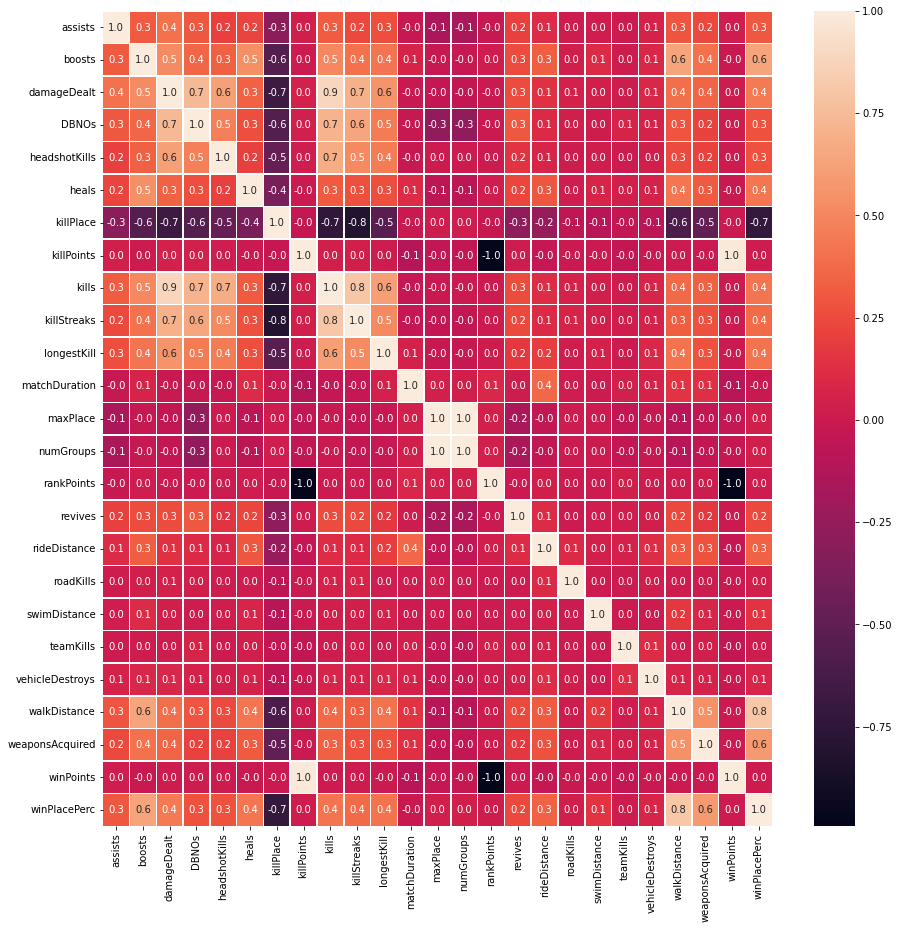

In [7]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [9]:
# 결측치 확인
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [5]:
# win Place Perc 결측 행 제거
train = train.dropna(axis=0)

In [6]:
# Id, groupId, matchId는 필요 없는 컬럼으로 판단하여 제거
train = train.drop(columns=["Id", "groupId", "matchId"])
train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 26 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int64  
 1   boosts           int64  
 2   damageDealt      float64
 3   DBNOs            int64  
 4   headshotKills    int64  
 5   heals            int64  
 6   killPlace        int64  
 7   killPoints       int64  
 8   kills            int64  
 9   killStreaks      int64  
 10  longestKill      float64
 11  matchDuration    int64  
 12  matchType        object 
 13  maxPlace         int64  
 14  numGroups        int64  
 15  rankPoints       int64  
 16  revives          int64  
 17  rideDistance     float64
 18  roadKills        int64  
 19  swimDistance     float64
 20  teamKills        int64  
 21  vehicleDestroys  int64  
 22  walkDistance     float64
 23  weaponsAcquired  int64  
 24  winPoints        int64  
 25  winPlacePerc     float64
dtypes: float64(6), int64(19), object(1)
memory

In [7]:
# 'matchType' 종류 확인
train.matchType.nunique()

16

In [8]:
train['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

In [9]:
# matchType 원-핫 인코딩
train = pd.get_dummies(train, columns=['matchType'])
train.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0.00,0,0,0,60,1241,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,91.47,0,0,0,57,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,68.00,0,0,0,47,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,32.90,0,0,0,75,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,100.00,0,0,0,45,0,1,1,...,0,0,0,0,0,0,0,1,0,0


In [29]:
# winPoints와 killPoints가 0이 아닌 행의 수가 같다.
# 외부 elo 점수를 보유한 유저의 데이터
#train_elo = train.loc[(train.killPoints!=0)]

## 데이터 분석

###kills

In [ ]:
train['kills'].value_counts()

In [10]:
# kills 29 이상인 행은 핵으로 판단하여 제거
train = train.loc[(train.kills < 29)]

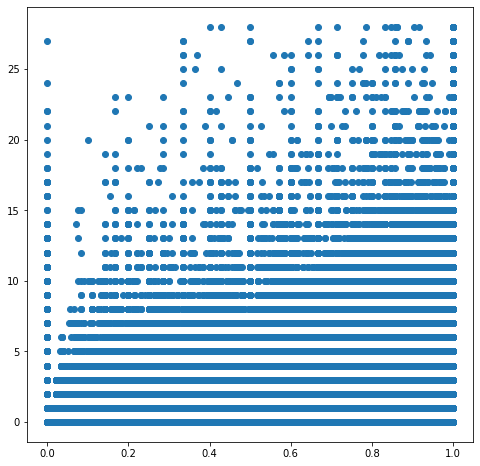

In [19]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x='winPlacePerc', y='kills', data=train)

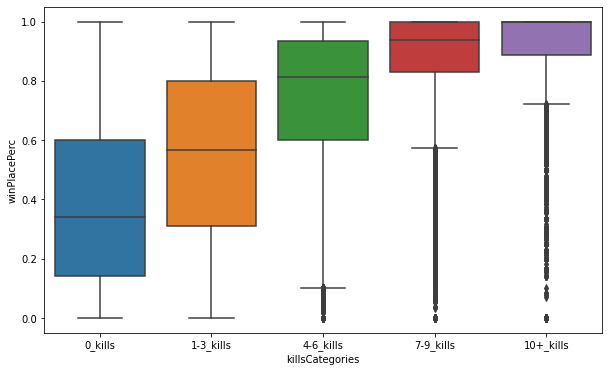

In [37]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 72], labels=['0_kills','1-3_kills', '4-6_kills', '7-9_kills', '10+_kills'])

plt.figure(figsize=(10,6))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

킬 수와 등수는 상관관계가 있다.

###boosts

In [36]:
train['boosts'].describe()

count    4.347246e+06
mean     1.132058e+00
std      1.726927e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      3.300000e+01
Name: boosts, dtype: float64

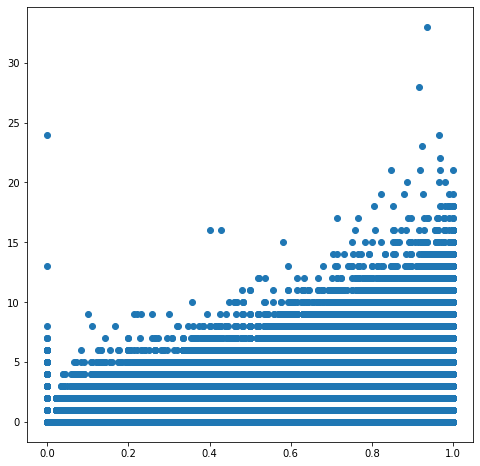

In [24]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x='winPlacePerc', y='boosts', data=train)

도핑 횟수와 등수는 상관관계가 있다

###damageDealt

In [35]:
train.damageDealt.describe()

count    4.347246e+06
mean     1.332140e+02
std      1.700461e+02
min      0.000000e+00
25%      0.000000e+00
50%      8.820000e+01
75%      1.896000e+02
max      3.407000e+03
Name: damageDealt, dtype: float64

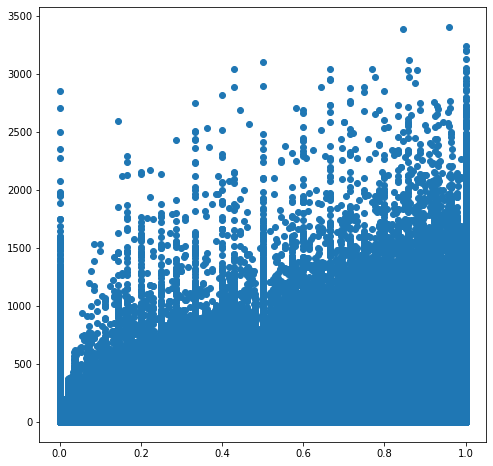

In [29]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x='winPlacePerc', y='damageDealt', data=train)

입힌 데미지와 등수는 상관관계가 있다

###walkDistance

In [32]:
train.walkDistance.describe()

count    4.347246e+06
mean     1.180677e+03
std      1.183872e+03
min      1.000000e-04
25%      1.724000e+02
50%      7.329000e+02
75%      2.008000e+03
max      2.578000e+04
Name: walkDistance, dtype: float64

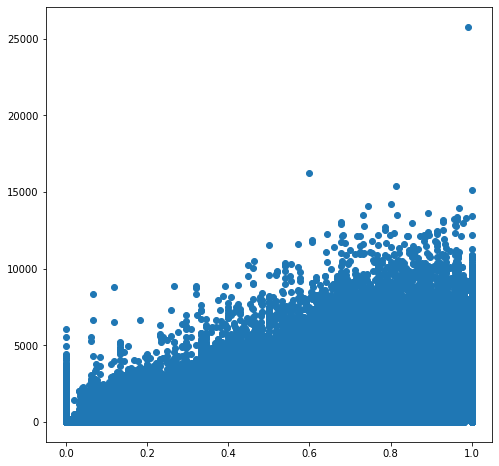

In [33]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x='winPlacePerc', y='walkDistance', data=train)

도보 이동거리는 등수와 상관관계가 있다

###weaponsAcquired

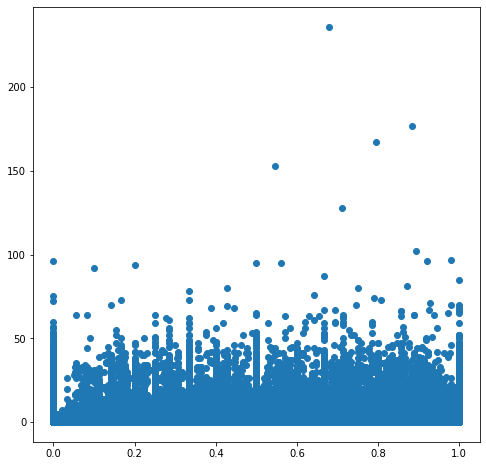

In [22]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x='winPlacePerc', y='weaponsAcquired', data=train)

###killPlace

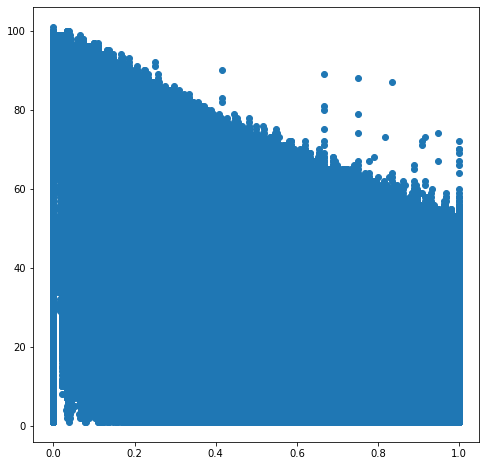

In [21]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x='winPlacePerc', y='killPlace', data=train)

In [ ]:
repeat = df.customer_id.value_counts().loc[df.customer_id.value_counts() >= 2]
repeat_index=repeat.index
repeat_index

Float64Index([ 98685.0,  50769.0,  40783.0, 496508.0,  23171.0, 427973.0,
              158374.0,  20784.0, 106662.0, 276705.0,
              ...
              403091.0, 639015.0, 605225.0, 519796.0, 113405.0,  48967.0,
              173849.0, 526243.0, 463248.0, 172581.0],
             dtype='float64', length=24765)

In [ ]:
df["customer_id"].value_counts() >= 2

98685.0      True
50769.0      True
40783.0      True
496508.0     True
23171.0      True
            ...  
545656.0    False
550306.0    False
550303.0    False
168905.0    False
610626.0    False
Name: customer_id, Length: 52178, dtype: bool

In [ ]:
repeat_index.isin([98685]).any() == True

True

In [ ]:
# 재구매 시 True, 1회 구매시 False 인 column 생성
def repeat_order_func(x) :      

    if repeat_index.isin([x]).any()==True:
        return True
    else:
        return False

df['repeat_order'] = df['customer_id'].map(repeat_order_func)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
df['repeat_order'].value_counts()

True     75517
False    27416
Name: repeat_order, dtype: int64

In [ ]:
# 재구매자만 있는 데이터프레임
df_repeat_order = df[df.repeat_order.isin([True])]

In [ ]:
# 강의를 1회만 구매한 사람 비율
re = df.customer_id.value_counts().loc[df.customer_id.value_counts() > 1]  

len(re)/len(df.customer_id.value_counts()) * 100

47.46253210165204

강의를 2회 이상 구매한 사람이 전체의 약47.5%